# 数据增广
增加一个已有的数据集，使得有更多的多样性
* 在语言里面加入各种不同的背景噪音
* 改变图片的颜色和形状
  
翻转：左右翻转，上下翻转（不总是有效）<br>
切割：从图片中切割一块然后变到固定形状
* 随机高宽比
* 随机大小
* 随机位置

颜色：改变色调，饱和度，明亮度<br>
实际上有更多其他的方法,Ps可以做的变换，都可以变换<br>

<img src='./image/dataAug.jpg' alt="dataAug" width=400 ><br>

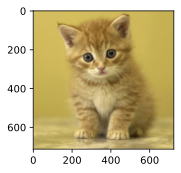

In [1]:
import torch
import torchvision
from torch import nn
from d2l import torch as d2l

d2l.set_figsize()
img = d2l.Image.open('./image/cat1.jpg')
d2l.plt.imshow(img)

In [2]:
def apply(img, aug, num_rows=2, num_cols=4, scale=1.5): # 生成8张图片，scale为大小
    Y = [aug(img) for _ in range(num_rows * num_cols)]
    d2l.show_images(Y, num_rows, num_cols, scale=scale)

左右翻转，p=0.5

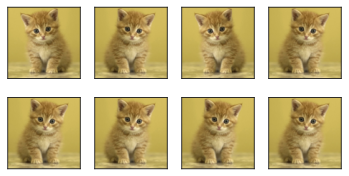

In [3]:
apply(img, torchvision.transforms.RandomHorizontalFlip())


上下翻转

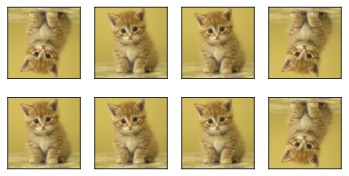

In [4]:
apply(img, torchvision.transforms.RandomVerticalFlip())

随机裁剪

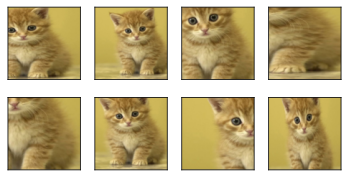

In [5]:
shape_aug = torchvision.transforms.RandomResizedCrop(
    (200, 200), scale=(0.1, 1), ratio=(0.5, 2)) # 最终的resize大小，裁剪区域的大小（随即选取一个值），高宽比
apply(img, shape_aug)

随机改变图像亮度


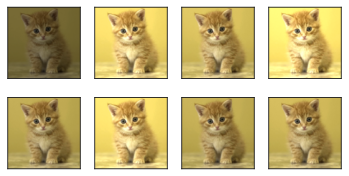

In [6]:
apply(img,
    torchvision.transforms.ColorJitter(brightness=0.5, contrast=0,
                                       saturation=0, hue=0))
# 亮度，对比度，饱和度，色温


随机改变图像色调

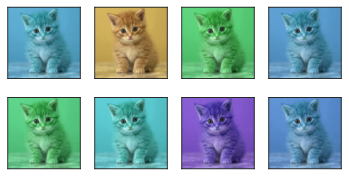

In [7]:
apply(img,
    torchvision.transforms.ColorJitter(brightness=0, contrast=0, saturation=0,
                                       hue=0.5))

组合

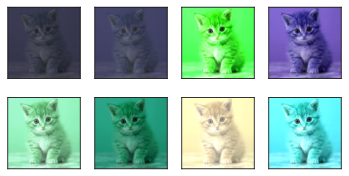

In [8]:
color_aug = torchvision.transforms.ColorJitter(brightness=0.5, contrast=0.5,
                                               saturation=0.5, hue=0.5)
apply(img, color_aug)

结合多种增广

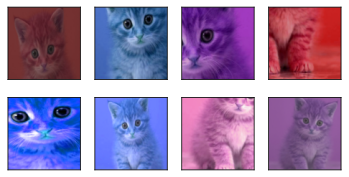

In [9]:
augs = torchvision.transforms.Compose([
    torchvision.transforms.RandomHorizontalFlip(), color_aug, shape_aug])
apply(img, augs)

使用图像增广进行训练

100.0%


Extracting ../data\cifar-10-python.tar.gz to ../data


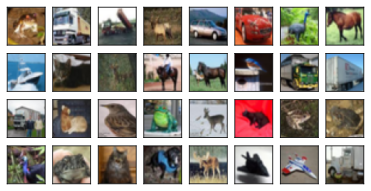

In [10]:
all_images = torchvision.datasets.CIFAR10(train=True, root="../data",
                                          download=True)
d2l.show_images([all_images[i][0] for i in range(32)], 4, 8, scale=0.8);

只是用最简单的随机左右翻转

In [11]:
train_augs = torchvision.transforms.Compose([
    torchvision.transforms.RandomHorizontalFlip(),
    torchvision.transforms.ToTensor()])

test_augs = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor()])

定义一个辅助函数，以便于读取图像和应用增广

In [12]:
def load_cifar10(is_train, augs, batch_size):
    # 在这里进行变换
    dataset = torchvision.datasets.CIFAR10(root="./data", train=is_train,
                                           transform=augs, download=True)
    dataloader = torch.utils.data.DataLoader(
        dataset, batch_size=batch_size, shuffle=is_train,
        num_workers=d2l.get_dataloader_workers())
    return dataloader

In [13]:
def train_batch_ch13(net, X, y, loss, trainer, devices):
    if isinstance(X, list): # 是否多GPU训练
        X = [x.to(devices[0]) for x in X] # 主GPU负责分发数据到其他GPU
    else:
        X = X.to(devices[0])
    y = y.to(devices[0])
    net.train()
    trainer.zero_grad()
    pred = net(X)
    l = loss(pred, y)
    l.sum().backward() # 如果x是list l也是，所以要相加
    trainer.step()
    train_loss_sum = l.sum()
    train_acc_sum = d2l.accuracy(pred, y)
    return train_loss_sum, train_acc_sum

def train_ch13(net, train_iter, test_iter, loss, trainer, num_epochs,
               devices=d2l.try_all_gpus()):
    """用多GPU进行模型训练"""
    timer, num_batches = d2l.Timer(), len(train_iter)
    animator = d2l.Animator(xlabel='epoch', xlim=[1, num_epochs], ylim=[0, 1],
                            legend=['train loss', 'train acc', 'test acc'])
    net = nn.DataParallel(net, device_ids=devices).to(devices[0]) # 指定主GPU
    for epoch in range(num_epochs):
        # 4个维度：储存训练损失，训练准确度，实例数，特点数
        metric = d2l.Accumulator(4)
        for i, (features, labels) in enumerate(train_iter):
            timer.start()
            l, acc = train_batch_ch13(
                net, features, labels, loss, trainer, devices)
            metric.add(l, acc, labels.shape[0], labels.numel())
            timer.stop()
            if (i + 1) % (num_batches // 5) == 0 or i == num_batches - 1:
                animator.add(epoch + (i + 1) / num_batches,
                             (metric[0] / metric[2], metric[1] / metric[3],
                              None))
        test_acc = d2l.evaluate_accuracy_gpu(net, test_iter)
        animator.add(epoch + 1, (None, None, test_acc))
    print(f'loss {metric[0] / metric[2]:.3f}, train acc '
          f'{metric[1] / metric[3]:.3f}, test acc {test_acc:.3f}')
    print(f'{metric[2] * num_epochs / timer.sum():.1f} examples/sec on '
          f'{str(devices)}')

In [14]:
batch_size, devices, net = 256, d2l.try_all_gpus(), d2l.resnet18(10, 3)

def init_weights(m):
    if type(m) in [nn.Linear, nn.Conv2d]:
        nn.init.xavier_uniform_(m.weight)

net.apply(init_weights)

def train_with_data_aug(train_augs, test_augs, net, lr=0.001):
    train_iter = load_cifar10(True, train_augs, batch_size)
    test_iter = load_cifar10(False, test_augs, batch_size)
    loss = nn.CrossEntropyLoss(reduction="none")
    trainer = torch.optim.Adam(net.parameters(), lr=lr) # 相对平滑的SGD
    train_ch13(net, train_iter, test_iter, loss, trainer, 10, devices)

loss 0.200, train acc 0.930, test acc 0.845
1719.7 examples/sec on [device(type='cuda', index=0)]


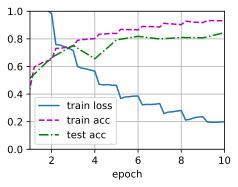

In [15]:
train_with_data_aug(train_augs, test_augs, net)
# 修改train_augs为test_augs测试增广的用处

## 小结

* 图像增广基于现有的训练数据生成随机图像，来提高模型的泛化能力。
* 为了在预测过程中得到确切的结果，我们通常对训练样本只进行图像增广，而在预测过程中不使用带随机操作的图像增广。
* 深度学习框架提供了许多不同的图像增广方法，这些方法可以被同时应用。